In [33]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [34]:
# Load datasets
df_fake = pd.read_csv("Fake.csv")
df_real = pd.read_csv("True.csv")

# Add labels
df_fake["label"] = 0  # Fake
df_real["label"] = 1  # Real

# Combine
df = pd.concat([df_fake, df_real], axis=0).reset_index(drop=True)

# Optional: Shuffle
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

display(df.head())

,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",1


In [35]:
df.drop(columns=["date", "subject"], inplace=True)  # Drop unnecessary columns
display(df.head())

,title,text,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",0
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,1
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,1
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",0
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",1


In [36]:
# Check total missing values per column
print(df.isnull().sum())

title    0
text     0
label    0
dtype: int64


In [37]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    # Lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # Tokenize
    words = text.split()
    # Remove stopwords & lemmatize
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return ' '.join(words)

# Apply to title and text
df["content"] = df["title"] + " " + df["text"]
df["content"] = df["content"].apply(preprocess)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\moham\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


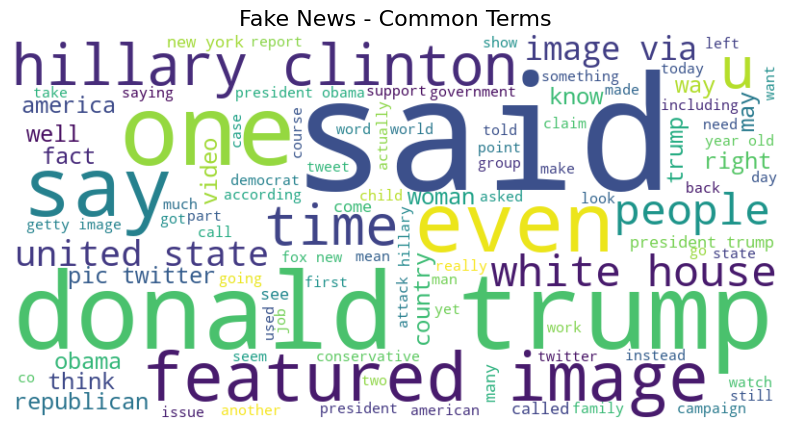

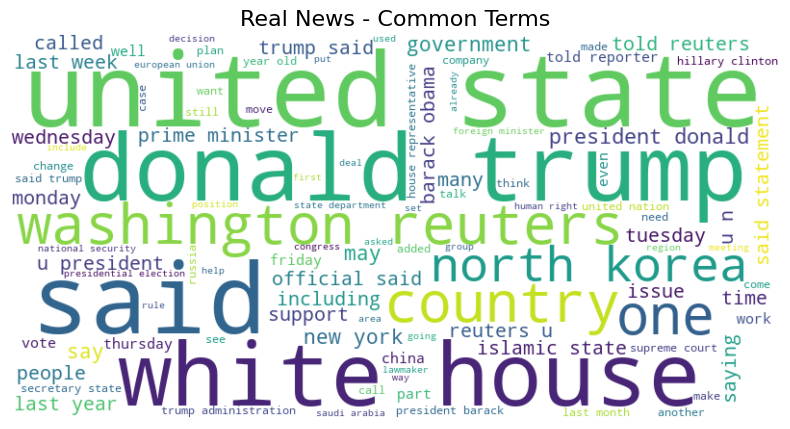

In [38]:
# Separate fake and real news
fake_text = " ".join(df[df['label'] == 0]['content'])
real_text = " ".join(df[df['label'] == 1]['content'])

# Create word clouds
wc_fake = WordCloud(width=800, height=400, background_color='white',
                    max_words=100).generate(fake_text)
wc_real = WordCloud(width=800, height=400, background_color='white',
                    max_words=100).generate(real_text)

# Plot Fake news word cloud
plt.figure(figsize=(10,5))
plt.imshow(wc_fake, interpolation='bilinear')
plt.axis('off')
plt.title("Fake News - Common Terms", fontsize=16)
plt.show()

# Plot Real news word cloud
plt.figure(figsize=(10,5))
plt.imshow(wc_real, interpolation='bilinear')
plt.axis('off')
plt.title("Real News - Common Terms", fontsize=16)
plt.show()


In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    df["content"], df["label"], test_size=0.2, random_state=42
)

In [40]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [41]:
model_svm = svm.LinearSVC()
model_svm.fit(X_train_tfidf, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [42]:
model = model_svm  

y_pred = model.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"F1-score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9940
F1-score: 0.9937

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      4710
           1       0.99      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



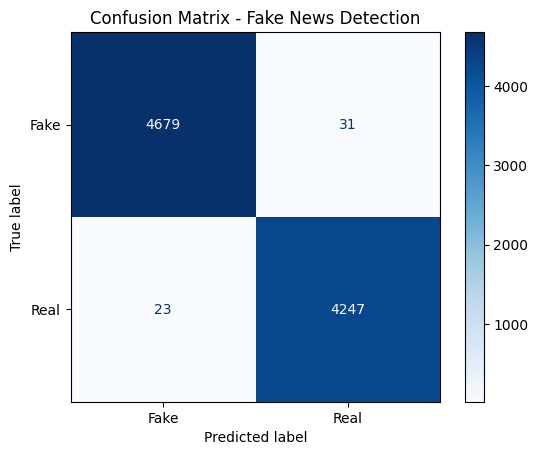

In [43]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Fake News Detection")
plt.show()